In [1]:
import numpy as np
import scipy.sparse
import networkx as nx
import random
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_fscore_support
from twittergraph import TwitterGraph as tg
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
graph = tg.rt_graph_from_json('/Volumes/pond/Temp/twitter/', 0)

In [4]:
first_split = datetime.datetime(2014, 5, 5) 
second_split = datetime.datetime(2014, 5, 10)
g_0 = tg.tg_by_removing_edges_after_date(graph, first_split)
g_1 = tg.tg_by_removing_edges_after_date(graph, second_split)
g_2 = tg.tg_with_tg(graph)

In [5]:
del graph

In [6]:
train_pairs = g_0.make_pairs_with_edges(g_1, .5)
test_pairs = g_1.make_pairs_with_edges(g_2, .5)

Found 17996 new edges out of 35993 total pairs
Found 9687 new edges out of 19375 total pairs


In [7]:
def normalize(mat):
    for i in range(mat.shape[0]):
        s = np.sum(mat[i])
        if s:
            mat[i] /= s
    return mat

In [8]:
def normalize2(mat):
    m = np.mean(mat)
    c_mat = np.zeros((mat.shape[0], mat.shape[0]))
    c_mat.fill(m)
    mat -= c_mat
    return mat

In [9]:
def load_adj(prefix, d):
    suffix = '.npz'
    mats = []
    for i in range(0, d):
        f_name = prefix + str(i) + suffix
        print("Loading (%d/%d): %s" % (i + 1, d, f_name))
        m = scipy.sparse.load_npz(f_name).todense()
        mats.append(normalize(m))
    return mats

In [10]:
A = load_adj('/Volumes/pond/Temp/SA_RT_ADJ/G_0/SA_RT_ADJ_', 11)

Loading (1/11): /Volumes/pond/Temp/SA_RT_ADJ/G_0/SA_RT_ADJ_0.npz


Loading (2/11): /Volumes/pond/Temp/SA_RT_ADJ/G_0/SA_RT_ADJ_1.npz


Loading (3/11): /Volumes/pond/Temp/SA_RT_ADJ/G_0/SA_RT_ADJ_2.npz


Loading (4/11): /Volumes/pond/Temp/SA_RT_ADJ/G_0/SA_RT_ADJ_3.npz


Loading (5/11): /Volumes/pond/Temp/SA_RT_ADJ/G_0/SA_RT_ADJ_4.npz


Loading (6/11): /Volumes/pond/Temp/SA_RT_ADJ/G_0/SA_RT_ADJ_5.npz


Loading (7/11): /Volumes/pond/Temp/SA_RT_ADJ/G_0/SA_RT_ADJ_6.npz


Loading (8/11): /Volumes/pond/Temp/SA_RT_ADJ/G_0/SA_RT_ADJ_7.npz


Loading (9/11): /Volumes/pond/Temp/SA_RT_ADJ/G_0/SA_RT_ADJ_8.npz


Loading (10/11): /Volumes/pond/Temp/SA_RT_ADJ/G_0/SA_RT_ADJ_9.npz


Loading (11/11): /Volumes/pond/Temp/SA_RT_ADJ/G_0/SA_RT_ADJ_10.npz


In [11]:
train_a = {}
for i in range(0, len(A)):
    train_a[i] = {}
    for u, v in train_pairs:
        if u not in train_a[i]:
            train_a[i][u] = {}
        train_a[i][u][v] = A[i][u - 1, v - 1]

In [12]:
del A

In [13]:
T = load_adj('/Volumes/pond/Temp/SA_RT_ADJ/G_1/SA_RT_ADJ_', 11)

Loading (1/11): /Volumes/pond/Temp/SA_RT_ADJ/G_1/SA_RT_ADJ_0.npz


Loading (2/11): /Volumes/pond/Temp/SA_RT_ADJ/G_1/SA_RT_ADJ_1.npz


Loading (3/11): /Volumes/pond/Temp/SA_RT_ADJ/G_1/SA_RT_ADJ_2.npz


Loading (4/11): /Volumes/pond/Temp/SA_RT_ADJ/G_1/SA_RT_ADJ_3.npz


Loading (5/11): /Volumes/pond/Temp/SA_RT_ADJ/G_1/SA_RT_ADJ_4.npz


Loading (6/11): /Volumes/pond/Temp/SA_RT_ADJ/G_1/SA_RT_ADJ_5.npz


Loading (7/11): /Volumes/pond/Temp/SA_RT_ADJ/G_1/SA_RT_ADJ_6.npz


Loading (8/11): /Volumes/pond/Temp/SA_RT_ADJ/G_1/SA_RT_ADJ_7.npz


Loading (9/11): /Volumes/pond/Temp/SA_RT_ADJ/G_1/SA_RT_ADJ_8.npz


Loading (10/11): /Volumes/pond/Temp/SA_RT_ADJ/G_1/SA_RT_ADJ_9.npz


Loading (11/11): /Volumes/pond/Temp/SA_RT_ADJ/G_1/SA_RT_ADJ_10.npz


In [14]:
test_a = {}
for i in range(0, len(T)):
    test_a[i] = {}
    for u, v in test_pairs:
        if u not in test_a[i]:
            test_a[i][u] = {}
        test_a[i][u][v] = T[i][u - 1, v - 1]

In [15]:
del T

In [64]:
beta = [.1, .1, .1, .1, .1, .1, .1, .1, .1, .1, .1]

In [54]:
a_train = nx.to_numpy_matrix(g_1.nx_graph)
a_test = nx.to_numpy_matrix(g_2.nx_graph)

In [55]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def h_theta():
    # Mohler's "P" function
    # sigma(i=1..n)(B_i * A_i)
    mat = np.zeros((A[0].shape[0], A[0].shape[1]))
    for i, b in enumerate(beta):
        mat += b * A[i]
    return sigmoid(mat)


def h_theta_single(u, v, test=False):
    p = 0
    if not test:
        for i in range(0, 11):
            p += beta[i] * train_a[i][u][v]
    else:
        for i in range(0, 11):
            p += beta[i] * test_a[i][u][v]
    return sigmoid(p)
    

"""
def dj_dtheta_j(h, j):
    # partial of J w.r.t. theta_j
    # definitely a way to do this step all at once as vector
    # need to make it simple for my feeble mind
    x_j = (beta[j] * A[j])
    start = 0
    der = 0
    m = 0
    for i in range(0, a_train.shape[0]):
        for j in range(start, a_train.shape[0]):
            der += ((h[i, j]) - a_train[i, j]) * x_j[i, j]
            m += 1
        start += 1
        # print("derivative: %.4f" % (der / m))
    return der / m

"""


def dj_dtheta_j_single(h, j, u, v):
    # partial of J w.r.t theta_j
    # h is the precomputed h_theta with the before theta parameters
    # j is the parameter of theta
    # (u, v) is the training example
    # x_j = (beta[j] * A[j])
    x_j_uv = train_a[j][u][v]  # x_j_uv = beta[j] * train_a[j][u][v]
    der = ((h - a_train[u - 1, v - 1]) * x_j_uv)
    return der


def cost():
    # log likelihood "J(theta)"
    # standard logistic regression cost function
    start = 0
    s = 0
    h = h_theta()
    m = 0
    for i in range(0, a_train.shape[0]):
        for j in range(start, a_train.shape[0]):
            m += 1
            y = a_train[i, j]
            p = h[i, j]
            s += y * np.log(p) + (y-1) * np.log(1 - p)
        start += 1
    return -s/m

def cost2():
    c = 0
    m = 0
    for u, v in train_pairs:
        m += 1
        y = a_train[u - 1, v - 1]
        p = h_theta_single(u, v)
        c += y * np.log(p) + (y-1) * np.log(1 - p)
    return -c / m

In [56]:
def stochastic_gradient_descent(alpha=1e-1, decay=0.999, epochs=10000, batch_size=256):
    eps = 0
    costs = []
    while eps < epochs:
        eps += 1
        batch = [int(random.random() * len(train_pairs)) for i in range(0, batch_size)]
       
        for i in batch:
            pair = train_pairs[i]
            u = pair[0]
            v = pair[1]
            h_uv = h_theta_single(u, v)
            for j in range(0, len(beta)):
                beta[j] -= alpha * dj_dtheta_j_single(h_uv, j, u, v)  # partial for single point, parameter
        alpha *= decay
        if eps % 100 == 0:
            costs.append(cost2())
        if eps % 1000 == 0:
            print("After %d epochs cost: %.5f, Alpha: %.5f" % (eps, cost2(), alpha))
            for j in range(0, len(beta)):
                print("\tBeta %d: %f" % (j, beta[j]))
    return costs

In [73]:
np.seterr(all='warn')  # get specifics if we underflow vs overflow etc...
costs = stochastic_gradient_descent(batch_size=400)

After 1000 epochs cost: -0.00017, Alpha: 0.03677
	Beta 0: 0.100000
	Beta 1: 0.100000
	Beta 2: 0.972231
	Beta 3: 0.597439
	Beta 4: 0.434811
	Beta 5: 0.377931
	Beta 6: 0.296925
	Beta 7: 0.300522
	Beta 8: 0.264519
	Beta 9: 0.279135
	Beta 10: 0.259709


After 2000 epochs cost: -0.00021, Alpha: 0.01352
	Beta 0: 0.100000
	Beta 1: 0.100000
	Beta 2: 1.319721
	Beta 3: 0.783908
	Beta 4: 0.560579
	Beta 5: 0.482563
	Beta 6: 0.370695
	Beta 7: 0.375572
	Beta 8: 0.325906
	Beta 9: 0.345984
	Beta 10: 0.319225


After 3000 epochs cost: -0.00023, Alpha: 0.00497
	Beta 0: 0.100000
	Beta 1: 0.100000
	Beta 2: 1.431295
	Beta 3: 0.851665
	Beta 4: 0.605075
	Beta 5: 0.521022
	Beta 6: 0.397494
	Beta 7: 0.403873
	Beta 8: 0.348591
	Beta 9: 0.371295
	Beta 10: 0.341368


After 4000 epochs cost: -0.00023, Alpha: 0.00183
	Beta 0: 0.100000
	Beta 1: 0.100000
	Beta 2: 1.475746
	Beta 3: 0.876886
	Beta 4: 0.621329
	Beta 5: 0.535116
	Beta 6: 0.407334
	Beta 7: 0.414058
	Beta 8: 0.356854
	Beta 9: 0.380379
	Beta 10: 0.349399


After 5000 epochs cost: -0.00023, Alpha: 0.00067
	Beta 0: 0.100000
	Beta 1: 0.100000
	Beta 2: 1.491670
	Beta 3: 0.886021
	Beta 4: 0.627282
	Beta 5: 0.540218
	Beta 6: 0.410900
	Beta 7: 0.417715
	Beta 8: 0.359827
	Beta 9: 0.383633
	Beta 10: 0.352283


After 6000 epochs cost: -0.00024, Alpha: 0.00025
	Beta 0: 0.100000
	Beta 1: 0.100000
	Beta 2: 1.497570
	Beta 3: 0.889368
	Beta 4: 0.629511
	Beta 5: 0.542100
	Beta 6: 0.412226
	Beta 7: 0.419072
	Beta 8: 0.360937
	Beta 9: 0.384844
	Beta 10: 0.353360


After 7000 epochs cost: -0.00024, Alpha: 0.00009
	Beta 0: 0.100000
	Beta 1: 0.100000
	Beta 2: 1.499582
	Beta 3: 0.890601
	Beta 4: 0.630303
	Beta 5: 0.542791
	Beta 6: 0.412707
	Beta 7: 0.419568
	Beta 8: 0.361339
	Beta 9: 0.385286
	Beta 10: 0.353751


After 8000 epochs cost: -0.00024, Alpha: 0.00003
	Beta 0: 0.100000
	Beta 1: 0.100000
	Beta 2: 1.500344
	Beta 3: 0.891048
	Beta 4: 0.630594
	Beta 5: 0.543040
	Beta 6: 0.412884
	Beta 7: 0.419748
	Beta 8: 0.361487
	Beta 9: 0.385446
	Beta 10: 0.353894


After 9000 epochs cost: -0.00024, Alpha: 0.00001
	Beta 0: 0.100000
	Beta 1: 0.100000
	Beta 2: 1.500641
	Beta 3: 0.891214
	Beta 4: 0.630703
	Beta 5: 0.543134
	Beta 6: 0.412949
	Beta 7: 0.419815
	Beta 8: 0.361542
	Beta 9: 0.385506
	Beta 10: 0.353947


After 10000 epochs cost: -0.00024, Alpha: 0.00000
	Beta 0: 0.100000
	Beta 1: 0.100000
	Beta 2: 1.500745
	Beta 3: 0.891274
	Beta 4: 0.630743
	Beta 5: 0.543167
	Beta 6: 0.412973
	Beta 7: 0.419839
	Beta 8: 0.361562
	Beta 9: 0.385528
	Beta 10: 0.353967


In [74]:
probs = []
actual = []
for u, v in test_pairs:
    probs.append(h_theta_single(u, v, test=True))
    actual.append(a_test[u - 1, v - 1])

In [75]:
print np.mean(probs)
print np.max(probs)
print np.min(probs)

0.500115091051
0.523451592535
0.5


In [76]:
print(roc_auc_score(actual, probs))
print(average_precision_score(actual, probs))

0.549839428062
0.601165401437


In [77]:
correct = 0
pred_pos = 0
pred_label = []
total = 0
for i, (u, v) in enumerate(test_pairs):
    total += 1
    if probs[i] > 0.500000693356:
        pred_label.append(1)
        pred_pos += 1
        if a_test[u - 1, v - 1]:
            correct += 1
    else:
        pred_label.append(0)
print("%d correct / %d predicted (%d total guess)" % (correct, pred_pos, total))

6240 correct / 12656 predicted (19375 total guess)


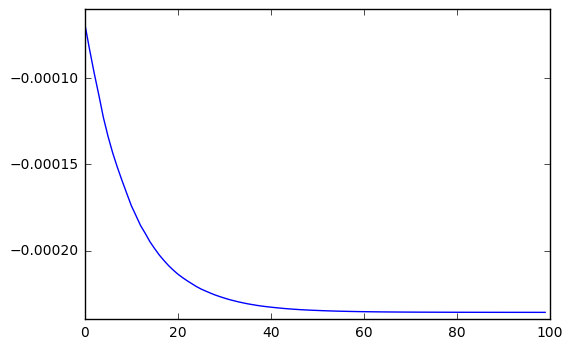

In [78]:
plt.plot(costs)

In [79]:
(pr, re, f, su) = precision_recall_fscore_support(actual, pred_label, average='binary')

In [79]:
print("Precision: %.4f" % pr)
print("Recall: %.4f" % re)
print("F-Measure: %.4f" % f)

Precision: 0.4930
Recall: 0.6442
F-Measure: 0.5586
